# ANN for Generalized Logistic Regression (Multinomial Logistic Regression)

In the following, we will create a Multi-Class Classification Deep Neural Net.  This will also function for binary classification as well since we are using a generalized version of Logistic Regression's activation function, $\sigma$, which is a *softmax activation* function.
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)
### Hyper-Parameters

For simplicity, I have used established conventions in deciding the particular hyper-parameters, however, their corresponding values can be adjusted.  The default values are based on concensus amongst the community.

Hyper-Parameters and their Values (if applicable)
- He Initialization
- L2 Regularization $\lambda : 0.1$
- ADAM Optimization 
$$\beta_1 : 0.9$$
$$\beta_2 : 0.999$$ 
$$\epsilon : 1e-8$$

In [53]:
%matplotlib inline
import scipy
from PIL import Image
from scipy import ndimage
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tf_utils import load_dataset,convert_to_one_hot
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  1.]]


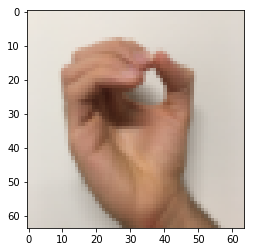

In [54]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print (Y_train)
plt.imshow(X_train_orig[1])

In [55]:
'''## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)'''

def classify(image_loc, actual, parameters):
    image = np.array(ndimage.imread(fname, flatten=False))
    nimage = scipy.misc.imresize(image, size=(64,64)).reshape((64*64*3,1))
    probs = predict(image, parameters)[0]
    a = accuracy(probs, actual)
    plt.imshow(image)
    print (a[1])

## Initialization

In [72]:
def init_params_he(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

        
    return parameters

def init_adam(parameters) :
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s
def update_par(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters['W{0}'.format(l+1)] = parameters['W{0}'.format(l+1)] - learning_rate*grads['dW{0}'.format(l+1)]
        parameters['b{0}'.format(l+1)] = parameters['b{0}'.format(l+1)] - learning_rate*grads['db{0}'.format(l+1)]
    return parameters

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    learning_rate = learning_rate * np.sqrt(1-np.power(beta2, t))/(1-np.power(beta1, t))

    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db" + str(l+1)]

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*np.square(grads["db" + str(l+1)])

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*np.divide(v["dW"+str(l+1)],
                                                                                          np.sqrt(s["dW"+str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*np.divide(v["db"+str(l+1)],
                                                                                          np.sqrt(s["db"+str(l+1)])+epsilon)

    return parameters, v, s

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
 
    np.random.seed(seed)            
    m = X.shape[1]                 
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m+1]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:m+1]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def dropout(A, keep_probs):
    D = np.random.rand(A.shape[0], A.shape[1])
    D = D<keep_probs
    A *= D
    A /= keep_probs
    return A, D

def reverse_dropout(dW, D, keep_probs):
    return dW*D[:,:dW.shape[1]]/keep_probs

def avg_grad(n_grads, c_grads, l):
    n = {}
    if c_grads:
        for i in c_grads:
            n[i] = (c_grads[:,:n_grads.shape[1]]*l + n_grads)/(l+1)
        return n
    else:
        return n_grads

In [57]:
def sigmoid(x):
    return 1/(1+np.exp(-x)), x
def sigmoid_backward(dA, cache):
    s = 1/(1+np.exp(-cache))
    return dA*s*(1-s)
def relu(x):
    return np.maximum(0, x), x
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ
def softmax(x):
    exps = np.exp(x)
    return exps/np.sum(exps, axis = 0, keepdims = True), x


In [66]:
def l_forward(A, W, b):
    return W.dot(A)+b, (A,W,b)
def lact_forward(A_prev, W, b, activation, keep_probs):
    #A_prev, D = dropout(A_prev, keep_probs)
    Z, l_cache = l_forward(A_prev, W, b)
    if activation == 'relu':
        A, a_cache = relu(Z)
    elif activation == 'softmax':
        A, a_cache = softmax(Z)
    elif activation == 'sigmoid':
        A, a_cache = sigmoid(Z)
    A, D = dropout(A, keep_probs)
    return A, (l_cache, a_cache, D)
def L_forward(X, parameters, classification, keep_probs):
    caches = []
    D_cache = []
    A = X
    L = len(parameters)//2
    for l in range(1, L):
        A_prev = A
        A, cache = lact_forward(A_prev, parameters['W{0}'.format(l)], parameters['b{0}'.format(l)], 'relu', keep_probs)
        caches.append(cache)
    AL, cache = lact_forward(A, parameters["W{0}".format(L)], parameters["b{0}".format(L)], classification, keep_probs = 1.0)
    caches.append(cache)
    return AL, caches

In [59]:
def l_backward(dZ, cache, lambd, m):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    if lambd:
        dW = 1./m * np.dot(dZ, A_prev.T) + W*lambd/m
    else:
        dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db
def lact_backward(dA, cache, lambd, m, activation, keep_probs):
    l_cache, a_cache, D = cache
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, a_cache)
    elif activation == 'relu':
        dZ = relu_backward(dA, a_cache)
    dA_prev, dW, db = l_backward(dZ, l_cache, lambd, m)
    dW = reverse_dropout(dW, D, keep_probs)
    return dA_prev, dW, db
def L_backward(AL, Y, caches, lambd, m, classification, keep_probs):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    current_cache = caches[L-1]
    if classification == 'softmax':
        dZ = (AL-Y)#/AL.shape[0]
        grads["dA{0}".format(L)], grads['dW{0}'.format(L)], grads['db{0}'.format(L)] = l_backward(dZ, current_cache[0], 
                                                                                                  lambd, m)
    elif classification == 'sigmoid':
        dAL = - (np.divide(Y,AL) - np.divide(1-Y, 1-AL))
        grads["dA{0}".format(L)], grads['dW{0}'.format(L)], grads['db{0}'.format(L)] = lact_backward(dAL, current_cache, 
                                                                                                     'sigmoid', lambd, m)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA{0}'.format(l+1)], grads['dW{0}'.format(l+1)], grads['db{0}'.format(l+1)] = lact_backward(grads['dA{0}'.format(l+2)], 
                                                                                                           current_cache,
                                                                                                           lambd, m, 
                                                                                                           activation = 'relu',
                                                                                                           keep_probs = keep_probs)
    return grads

In [60]:
def predict(inp, parameters):
    probs, weights= L_forward(inp, parameters, classification = 'softmax')
    return (probs==probs.max(axis = 0, keepdims=1)).astype(float), weights
def accuracy(preds, actual):
    return sum(sum(preds == actual)==preds.shape[0])/preds.shape[1], preds
def compute_cost(preds, actual):
    ind = np.argmax(actual, axis = 0)
    log_probs = np.log(np.choose(ind, preds))
    return -1*np.sum(log_probs)/len(log_probs)
def l2_loss(params, lambd):
    weight_loss = []
    for i in range(len(params)//2):
        weight_loss.append(0.5*lambd*np.sum(np.square(params['W{0}'.format(i+1)])))
    return sum(weight_loss)

In [64]:
def L_model(X, Y, X_test, Y_test, layer_dims, mini_batch_size = 32, learning_rate = 0.0075, 
            beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, epoch = 3000, keep_probs = 0.5,
            lambd = 0.1, print_cost=True, plot=True, classification = 'sigmoid'):
    print
    np.random.seed(1)
    costs = []
    ac = []
    parameters = init_params_he(layer_dims)
    v, s = init_adam(parameters)
    t = 0
    seed = 10
    for i in range(epoch):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        c_grads = None
        for l, minibatch in enumerate(minibatches):
            (minibatch_X, minibatch_Y) = minibatch
            AL, caches = L_forward(minibatch_X, parameters, classification, keep_probs)
            c = compute_cost(AL, minibatch_Y)
            if lambd:
                c += l2_loss(parameters, lambd)
            c_grads = avg_grad(L_backward(AL, minibatch_Y, caches, lambd, minibatch_X.shape[1], classification, keep_probs), c_grads, l)
            t+=1
            parameters, v, s = update_parameters_with_adam(parameters, c_grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        if print_cost and i%20==0:
            print ("Cost after epoch {0}: {1}".format(i, c))
            costs.append(c)
            ac_train = accuracy(predict(X, parameters)[0], Y)[0]
            ac_test = accuracy(predict(X_test, parameters)[0], Y_test)[0]
            print ("Training Set Accuracy after epoch {0}: {1}".format(i, ac_train))
            print ("Test Set Accuracy after epoch {0}: {1}".format(i, ac_test))
            ac.append(ac_train)
    # plot the cost
    if plot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        plt.plot(ac)
        plt.ylabel('Accuracy Score')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

In [73]:
p = L_model(X_train, Y_train, X_test, Y_test, mini_batch_size = 32, learning_rate = 0.0001, epoch = 3000, 
            layer_dims = [12288, 25, 12, 6], 
            classification = 'softmax', lambd = None)

ValueError: operands could not be broadcast together with shapes (25,12288) (25,32) 

## Testing Round

In [74]:
t_p = init_params_he([10, 7, 4, 2])

In [75]:
t_x = 

{'W1': array([[ 0.79989897,  0.19521314,  0.04315498, -0.83337927, -0.12405178,
         -0.15865304, -0.03700312, -0.28040323, -0.01959608, -0.21341839],
        [-0.58757818,  0.39561516,  0.39413741,  0.76454432,  0.02237573,
         -0.18097724, -0.24389238, -0.69160568,  0.43932807, -0.49241241],
        [-0.52996892, -0.09196943,  0.66462575,  0.10586273, -0.45785063,
         -0.31886025,  0.27961805, -0.07178376, -0.34383407, -0.10287287],
        [ 0.33319929,  0.88374361, -0.55638887, -0.28014216, -0.35945513,
         -1.08184688, -0.41313235, -0.45789116,  0.50265822, -0.05899384],
        [-0.72595532,  0.28920205, -0.15932913, -0.77955637, -0.26682983,
         -0.26322741, -0.39081204,  0.01328842, -1.00545144, -0.11974675],
        [ 0.45310941,  0.38138279,  0.49559652,  0.50060672,  0.66524951,
         -0.50011927,  0.3782682 , -0.8322151 , -0.26961842, -0.85617793],
        [ 0.46874582,  0.59646569, -0.08828653,  0.79364539, -0.30174732,
          0.06735791,  0.0